Dynamics-informed deconvolutional neural networks for super-resolution identification of regime changes in epidemiological time series
===

_Jose M. G. Vilar$^{1, 2, *}$ and Leonor Saiz$^{3, *}$  
$^1$Biofisika Intitute (CSIC, UPV/EHU), University of the Basque Country, P.O. Box 644, 48080 Bilbao, Spain  
$^2$IKERBASQUE, Basque Foundation for Science, 48011 Bilbao, Spain  
$^3$Department of Biomedical Engineering, University of California, 451 East Health Sciences Drive, Davis, CA 95616, USA_

$^*$ To whom correspondence should be addressed: j.vilar@ikerbasque.org or lsaiz@ucdavis.edu

SUMMARY: 
Notebook to reproduce Figures 2, 3, 4, and 5 of reference [1].

This notebook is provided to ensure reproducibility of the analyses and has not been optimized for general usage. It was executed on a GeForce RTX 3090 with python 3.8.12 from the conda 22.11.1 (https://anaconda.org/) distribution with the additional packages cudnn 8.4.1.50, tensorflow 2.9.1, numpy 1.23.1, pandas 1.5.0, matplotlib 3.6.0, and scipy 1.9.1.

REFERENCE:

[1] J.M.G. Vilar and L. Saiz, Dynamics-informed deconvolutional neural networks for super-resolution identification of regime changes in epidemiological time series, submitted (2022).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


In [2]:
inital_ext = 80
dd = pd.read_csv('ddeaths.csv', index_col=0, parse_dates=True)
number_of_locations = dd.shape[1]
rindex = pd.date_range(start=dd.index[0] - pd.to_timedelta(inital_ext, 'D'),
                       end=dd.index[-1],
                       freq='1D')
ddi = pd.DataFrame(dd, index=rindex).fillna(0)
for i in range(number_of_locations):
    cutoff_day = np.sum(ddi.iloc[:, i].cumsum() <
                        ddi[:'2020-5-1'].max()[i]/100)
    m1 = ddi.iloc[cutoff_day:cutoff_day+7, i].mean()
    m2 = ddi.iloc[cutoff_day+7:cutoff_day+14, i].mean()
    gr = np.log(m2/m1)/7
    tmp = ddi.rolling(3, center=True).mean(
    ).iloc[cutoff_day:cutoff_day+7, i].values*(m1/m2)
    for j in range(12):
        ddi.iloc[cutoff_day-7*(j + 1):cutoff_day-7*j, i] = (tmp > 0)*(tmp)
        tmp = tmp*(m1/m2)
daily_deaths = ddi


In [3]:
import  os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


In [4]:
import random


def set_seed(seed=7):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.compat.v1.set_random_seed(seed)
    tf.experimental.numpy.random.seed(seed)
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ["PYTHONHASHSEED"] = str(seed)


set_seed()


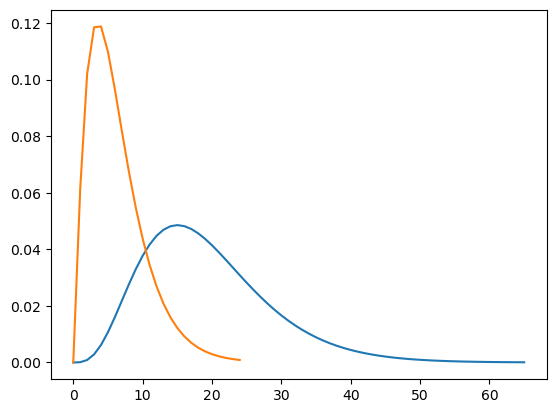

In [5]:
from scipy.stats import gamma


def gammapdf(x, m, sd):
    return gamma.pdf(x, m**2/sd**2, 0, sd**2/m)


ID_kernel_length = 65
xx = np.arange(0, ID_kernel_length+1, 1)
ID_kernel = gammapdf(xx, 19.3, 9.1)
ID_kernel = ID_kernel/ID_kernel.sum()
plt.plot(xx, ID_kernel)

GT_kernel_length = 25
GT_kernel = gammapdf(xx[:GT_kernel_length], 6.3, 4.2)
GT_kernel = pd.Series(GT_kernel).values
GT_kernel = GT_kernel[::]/GT_kernel.sum()
plt.plot(xx[:GT_kernel_length], GT_kernel)


In [6]:
reg_coeff = np.array(sum([number_of_locations*[i, ]
               for i in 10**np.arange(-1-0.05, 1+1e-10, 0.05)], []))[:, np.newaxis]
reg_coeff[:number_of_locations] = 0
number_reg_coeffs=len(reg_coeff)//number_of_locations


In [7]:
y=pd.concat(number_reg_coeffs*[daily_deaths,],axis=1).values[np.newaxis,:,:]
x=pd.DataFrame(ID_kernel).values[:].reshape(-1,ID_kernel_length+1,1)

display([y.shape, x.shape])

[(1, 851, 210), (1, 66, 1)]

In [8]:
e1 = 1e-4
e2 = 1e-1


def custom_loss(y_true, y_pred):
    aa = 1/tf.reduce_mean(1/(1+y_pred[:, inital_ext:-ID_kernel_length, :]), axis=1)
    squared_difference = (y_pred+tf.math.lgamma(y_true+1) -
                          y_true*(tf.math.log(e1+y_pred)))/(1+y_pred)
    return tf.reduce_mean(aa*(squared_difference[:, inital_ext:-ID_kernel_length, :]), axis=-2)


def custom_regularizer(weights):
    lw = tf.math.log(e2+weights)[GT_kernel_length - 1:]
    lws = tf.math.log(e2+tf.transpose(tf.nn.conv1d(tf.transpose(weights, [1, 0, 2]),
                                                   tf.constant(GT_kernel[::-1],
                                                               shape=[GT_kernel_length, 1, 1],
                                                               dtype=tf.float32),
                                                   stride=1,
                                                   padding='VALID'), [1, 0, 2]))
    return tf.reduce_mean(reg_coeff*tf.reduce_mean((tf.math.abs(lw[1:]-lw[:-1]-lws[1:]+lws[:-1]))[:-ID_kernel_length], axis=0))


input = tf.keras.Input(shape=(ID_kernel_length+1, 1))

main_layer = tf.keras.layers.Conv1DTranspose(
    y.shape[2],
    y.shape[1] - ID_kernel_length,
    use_bias=False,
    kernel_regularizer=custom_regularizer,
    kernel_constraint=tf.keras.constraints.NonNeg(),
    kernel_initializer=tf.keras.initializers.Constant(
        daily_deaths.values.mean()))(input)

model_didnn = tf.keras.Model(input, main_layer, name="didnn")
model_didnn.summary()


Model: "didnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 66, 1)]           0         
                                                                 
 conv1d_transpose (Conv1DTra  (None, 851, 210)         165060    
 nspose)                                                         
                                                                 
Total params: 165,060
Trainable params: 165,060
Non-trainable params: 0
_________________________________________________________________


In [9]:
for i in range(0, 10*8+1):
    lrv = 10**(4-i/10.0)
    model_didnn.compile(optimizer=tf.optimizers.Adamax(
        learning_rate=lrv), loss=custom_loss)
    res = model_didnn.fit(x, y, epochs=50000, verbose=0)
    print(i, lrv, res.history['loss'][-1])


0 10000.0 343.6942443847656
1 7943.282347242814 253.2452392578125
2 6309.57344480193 234.43975830078125
3 5011.872336272725 192.04275512695312
4 3981.0717055349733 181.9593048095703
5 3162.2776601683795 135.49102783203125
6 2511.88643150958 117.93109893798828
7 1995.2623149688789 97.57686614990234
8 1584.893192461114 81.62615203857422
9 1258.9254117941675 69.58185577392578
10 1000.0 53.8188362121582
11 794.3282347242813 43.648590087890625
12 630.957344480193 34.7811279296875
13 501.18723362727246 26.83055877685547
14 398.1071705534973 19.804243087768555
15 316.22776601683796 16.25261688232422
16 251.18864315095797 12.434489250183105
17 199.52623149688787 10.33729362487793
18 158.48931924611142 8.4295015335083
19 125.89254117941675 6.6256208419799805
20 100.0 5.473753929138184
21 79.43282347242814 4.623147487640381
22 63.0957344480193 4.038113117218018
23 50.11872336272725 3.526848077774048
24 39.810717055349734 3.137425184249878
25 31.622776601683793 2.8458664417266846
26 25.1188643150

In [10]:
y_predicted = model_didnn.predict(x, verbose=0)
scaled_incidence = model_didnn.get_weights()[0]


def custom_loss_np(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    return custom_loss(y_true, y_pred)


def custom_regularizer_AIC(weights):
    lw = tf.math.log(e2+weights)[GT_kernel_length-1:-ID_kernel_length, :, :]
    lws = tf.math.log(e2 +
                      tf.transpose(tf.nn.conv1d(tf.transpose(weights, [1, 0, 2]),
                                                tf.constant(
                                                    GT_kernel[::-1], shape=[GT_kernel_length, 1, 1], dtype=tf.float32),
                                                stride=1, padding='VALID'), [1, 0, 2])
                      )[:-ID_kernel_length, :, :]
    return np.sum(tf.math.abs(lw[1:]-lw[:-1]-lws[1:]+lws[:-1]) > 10**-3, axis=0)


In [11]:
last_day = inital_ext+365
AIC_values = [((2*(custom_regularizer_AIC(scaled_incidence[inital_ext-GT_kernel_length:last_day-GT_kernel_length, :, :]).flatten())
           + y_predicted[:, inital_ext:last_day, :].shape[1]*2*((custom_loss_np(y[:, inital_ext:last_day, :], y_predicted[:, inital_ext:last_day, :]).numpy()).flatten()))[i::number_of_locations])
           for i in range(number_of_locations) if daily_deaths.columns[i]!='Italy']
AIC_min = np.argmin(np.sum(np.array(AIC_values), axis=0))

print(f'Regularization term γ according to AIC: {reg_coeff[AIC_min*number_of_locations,0]:.2f}')

Regularization term γ according to AIC: 2.00


In [12]:
NPIs = {'Italy': ['2020-02-22',
                  '2020-03-04',
                  '2020-03-11',
                  '2020-10-08',
                  '2020-10-24',
                  '2020-11-05',
                  '2021-01-07',
                  ],
        'Spain': ['2020-03-14',
                  '2020-07-1',
                  '2020-09-7',
                  '2020-10-26',
                  '2021-01-13',
                  ],
        'Denmark': ['2020-03-18',
                    '2020-12-25',
                    '2021-01-06',
                    ],
        'England': ['2020-3-13',
                    '2020-03-23',
                    '2020-08-21',
                    '2020-10-17',
                    '2020-10-24',
                    '2020-11-5',
                    '2020-12-2',
                    '2021-1-6',
                    ],
        'Switzerland': ['2020-03-13',
                        '2020-03-21',
                        '2020-08-31',
                        '2020-09-24',
                        '2020-10-23',
                        ],
        }


In [13]:
def print2(*x):
    x = [f'{i:.2f}' if isinstance(i, float) else i for i in x]
    print(*x)

def ln_Rt(weights):
    lw = tf.math.log(e2+weights)[GT_kernel_length-1:]
    lws = tf.math.log(e2+tf.transpose(tf.nn.conv1d(tf.transpose(weights, [1, 0, 2]),
                                                   tf.constant(GT_kernel[::-1],
                                                   shape=[GT_kernel_length, 1, 1], dtype=tf.float32),
                                                   stride=1, padding='VALID'), [1, 0, 2]))
    return lw[:]-lws[:]


In [14]:
dd_index = daily_deaths[inital_ext:-ID_kernel_length].index.values

rc_i_min, RMSD_min = 0, 100
for rc_i in range(number_reg_coeffs):
    NPI_offsets = []
    ln_Rt_values = ln_Rt(scaled_incidence)[
        inital_ext-(GT_kernel_length-1):-ID_kernel_length-(GT_kernel_length-1), :, 0]
    for i in range(number_of_locations):
        gr = pd.Series(ln_Rt_values[:, number_of_locations*rc_i+i],
                       index=dd_index[:len(ln_Rt_values)])
        grd = np.exp(gr).diff()
        location = daily_deaths.columns[i]
        for j in NPIs[location]:
            tj = pd.to_datetime(j)
            t1d = pd.to_timedelta('1D')
            grdc = grd[tj-4*t1d:tj+4*t1d]
            NPI_offsets.append((grdc.index[grdc.abs().argmax()]-tj)/t1d)
    RMSD = (np.array(NPI_offsets)**2).mean()**0.5
    print2(rc_i, reg_coeff[rc_i*number_of_locations,0], RMSD,
           np.array(NPI_offsets).mean(), np.array(NPI_offsets).std())
    if RMSD < RMSD_min:
        rc_i_min, RMSD_min, = rc_i, RMSD
print2(rc_i_min, reg_coeff[rc_i_min*number_of_locations,0], RMSD_min)
print('')
print(f'Regularization term γ with lowest RMSD: {reg_coeff[rc_i_min*number_of_locations,0]:.2f}')
print(f'Lowest RMSD: {RMSD_min:.2f}')

0 0.00 2.52 0.07 2.52
1 0.10 2.67 0.04 2.67
2 0.11 2.47 0.11 2.47
3 0.13 2.67 -0.25 2.65
4 0.14 2.43 0.00 2.43
5 0.16 2.56 -0.11 2.55
6 0.18 2.63 -0.36 2.61
7 0.20 2.63 0.04 2.63
8 0.22 2.54 0.25 2.53
9 0.25 2.38 0.32 2.36
10 0.28 2.56 -0.39 2.53
11 0.32 2.45 -0.21 2.44
12 0.35 2.38 -0.25 2.37
13 0.40 2.31 -0.32 2.28
14 0.45 2.17 -0.21 2.16
15 0.50 2.09 -0.14 2.08
16 0.56 1.91 -0.14 1.90
17 0.63 2.07 -0.14 2.07
18 0.71 2.13 -0.54 2.06
19 0.79 2.02 -0.43 1.97
20 0.89 1.77 0.00 1.77
21 1.00 1.75 -0.14 1.75
22 1.12 1.72 -0.18 1.71
23 1.26 1.43 -0.04 1.43
24 1.41 1.35 0.04 1.35
25 1.58 1.21 -0.04 1.21
26 1.78 1.13 -0.07 1.13
27 2.00 1.10 0.00 1.10
28 2.24 1.07 0.00 1.07
29 2.51 0.93 -0.07 0.92
30 2.82 1.15 -0.04 1.15
31 3.16 1.22 0.00 1.22
32 3.55 1.41 0.07 1.41
33 3.98 1.44 0.14 1.43
34 4.47 1.61 0.25 1.60
35 5.01 1.65 0.29 1.62
36 5.62 1.71 0.21 1.70
37 6.31 2.05 0.71 1.92
38 7.08 2.01 0.46 1.95
39 7.94 1.82 0.68 1.69
40 8.91 2.09 0.79 1.93
41 10.00 1.95 0.46 1.90
29 2.51 0.93

Regulariz

In [15]:
mp7 = np.concatenate([model_didnn.predict(x, verbose=0)[0, inital_ext+GT_kernel_length-1:-ID_kernel_length, rc_i_min*number_of_locations+j]
                     for j, i in enumerate(daily_deaths.columns)])
ya7 = np.concatenate([y[0, inital_ext+GT_kernel_length-1:-ID_kernel_length, rc_i_min*number_of_locations+j]
                     for j, i in enumerate(daily_deaths.columns)])

print(f'Test for Poisson: {np.mean((ya7-mp7)**2/mp7):.2f}')

Test for Poisson: 1.22


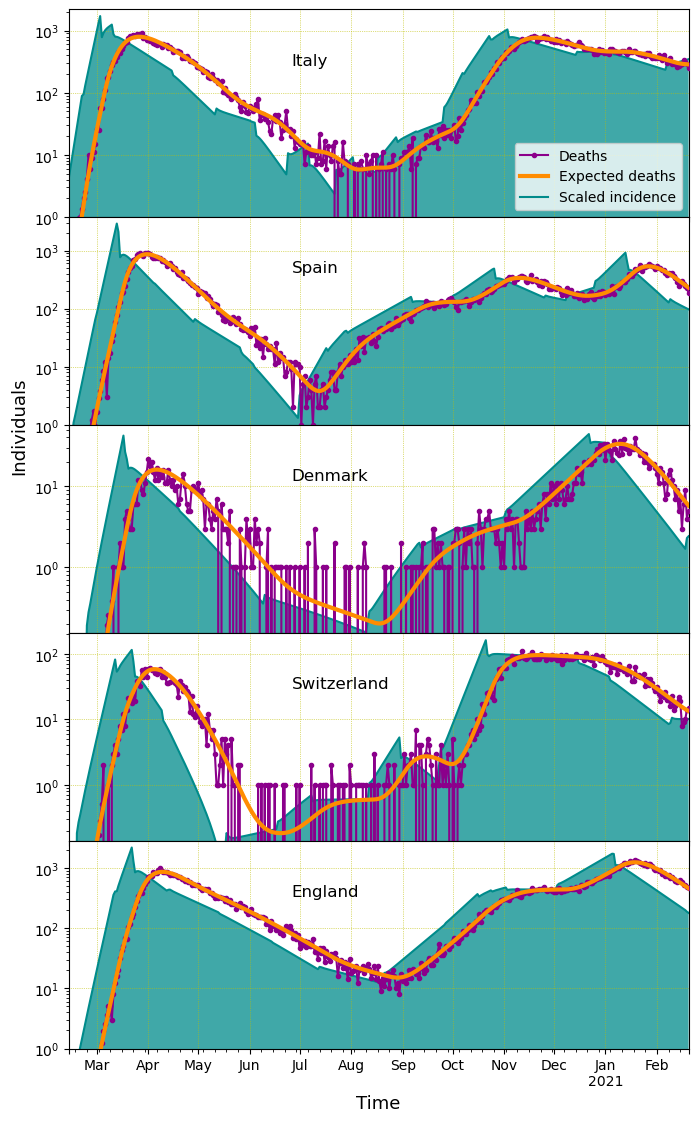

In [16]:
y_pred = model_didnn.predict(x, verbose=0)
sis = scaled_incidence[inital_ext:-ID_kernel_length, :, 0]
fig = plt.figure(figsize=(8, 2.5*number_of_locations+1-0))
gs = fig.add_gridspec(number_of_locations, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)
ii = 0
for j in range(number_of_locations):
        i=rc_i_min*number_of_locations+j
        ax = axs[ii]
        ii = ii+1
        sdate, edate = '2020-02-10', '2021-02-20'
        ws = pd.Series(sis[:, i], index=dd_index[:-ID_kernel_length])[sdate:edate]
        ax.fill_between(ws.index, ws.values, fc='darkcyan',
                        alpha=0.75, label=None)
        ys = pd.Series(y[0, inital_ext:-ID_kernel_length, i], index=dd_index[:])[sdate:edate]
        ys.plot(ax=ax,
                marker='.', c='darkmagenta', label='Deaths', zorder=10)
        yps = pd.Series(y_pred[0, inital_ext:-ID_kernel_length, i], index=dd_index[:])[sdate:edate]
        yps.plot(ax=ax, lw=3, c='darkorange', label='Expected deaths', zorder=10)
        ws.plot(ax=ax, c='darkcyan',
                label='Scaled incidence')
        ax.set_ylim(
            ymin=min(1, yps['2020-04-01':].min()/1.3), ymax=1.3*ws.max())
        ax.set_yscale('log')
        if ii == 1:
            ax.legend()
        wbei = reg_coeff[i]
        ax.set_title(daily_deaths.columns[j]
                     , y=1.0, x=0.36, loc='left', pad=-40)
        ax.grid(c='y', ls=':', lw=0.5)
plt.ylabel('Individuals', y=3, size=13)
plt.xlabel('Time', size=13)
for ex in ['.pdf', '.svg', '.png']:
    plt.savefig('fig2'+ex, transparent=True, bbox_inches='tight')
plt.show()

Italy
2020-02-22 0.00
2020-03-04 0.00
2020-03-11 0.00
0.00 0.00
Spain
2020-03-14 0.00
0.00 0.00
Denmark
2020-03-18 0.00
0.00 0.00
Switzerland
2020-03-13 0.00
2020-03-21 2.00
1.00 1.00
England
2020-03-13 0.00
2020-03-23 0.00
0.00 0.00
0.22 0.63


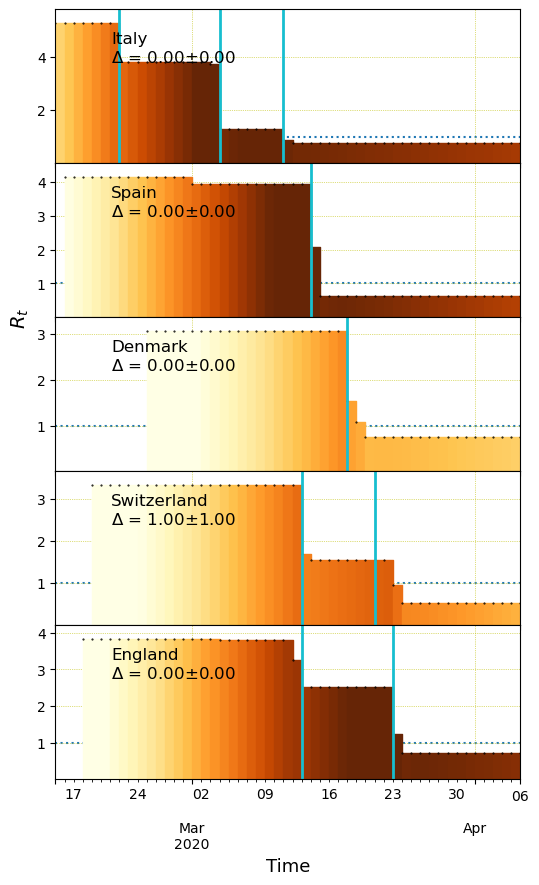

Italy
2020-02-22 0.00
2020-03-04 0.00
2020-03-11 0.00
2020-10-08 0.00
2020-10-24 0.00
2020-11-05 -1.00
2021-01-07 -1.00
-0.29 0.45
Spain
2020-03-14 0.00
2020-07-01 0.00
2020-09-07 0.00
2020-10-26 1.00
2021-01-13 1.00
0.40 0.49
Denmark
2020-03-18 0.00
2020-12-25 -2.00
2021-01-06 -2.00
-1.33 0.94
Switzerland
2020-03-13 0.00
2020-03-21 2.00
2020-08-31 0.00
2020-09-24 0.00
2020-10-23 -1.00
0.20 0.98
England
2020-03-13 0.00
2020-03-23 0.00
2020-08-21 0.00
2020-10-17 0.00
2020-10-24 1.00
2020-11-05 -2.00
2020-12-02 1.00
2021-01-06 1.00
0.12 0.93
-0.07 0.92


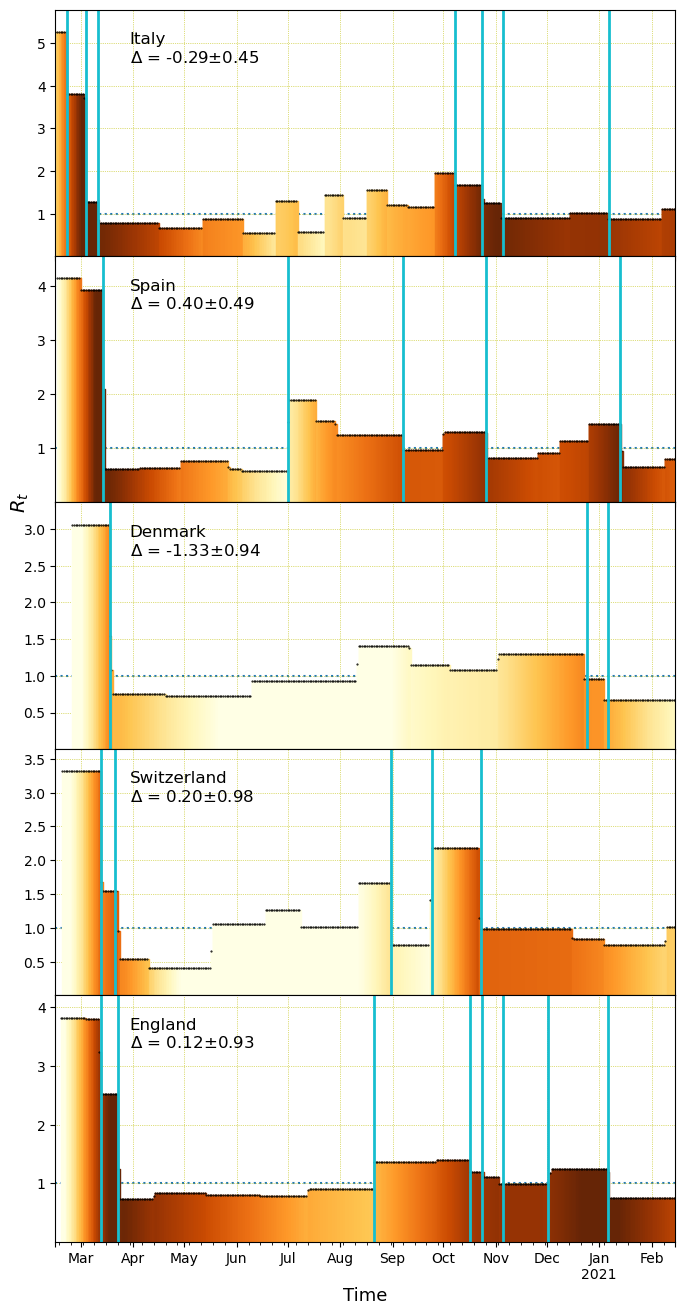

In [17]:
for f_i in range(2):
    fig = plt.figure(figsize=(8-2, 2*number_of_locations)
                     if f_i == 0 else (8, 16))
    gs = fig.add_gridspec(number_of_locations, hspace=0)
    axs = gs.subplots(sharex=True, sharey=False)
    ii = 0
    ser, sert = [], []
    Rt = np.exp(ln_Rt(scaled_incidence)[
        inital_ext-(GT_kernel_length-1):-ID_kernel_length-(GT_kernel_length-1), :, 0])
    for k in range(number_of_locations):
        i = rc_i_min*number_of_locations+k
        print(daily_deaths.columns[k])
        ax = axs[ii]
        ii = ii+1
        ws = pd.Series(scaled_incidence[inital_ext:-ID_kernel_length, i, 0],
                       index=dd_index[:-ID_kernel_length])
        gr = pd.Series(Rt[:, i], index=dd_index[:len(Rt)])
        sdl = gr[(gr.diff() > 0.05) | (gr > 8)][:'2020-3-10'].index
        sd1 = '2020-2-15' if len(sdl) == 0 else sdl[-1]
        ed1 = '2021-3-1'
        ws = ws[sd1:ed1]
        gr = gr[sd1:ed1]
        gr.plot(ax=ax, marker='.', ms=1, c='k', lw=0, alpha=1,
                drawstyle="steps-post", label=daily_deaths.columns[k])
        y_p, x_p = gr.values, gr.index
        x_x, y_y, g_g = ws.index, ws.values, gr.values
        for i_i in range(len(x_x) - 1):
            ax.fill_between([x_x[i_i], x_x[i_i+1]],
                            [g_g[i_i], g_g[i_i+1]],
                            color=plt.get_cmap("YlOrBr")(np.log10(y_y[i_i])/3), step="post", zorder=1)

        grd = (gr).diff()
        serl = []
        for j in NPIs[daily_deaths.columns[k]][:]:
            tj = pd.to_datetime(j)
            if tj < pd.to_datetime('2020-5-1' if f_i == 0 else '2021-5-1'):
                t1d = pd.to_timedelta('1D')
                grdc = grd[tj-4*t1d:tj+4*t1d]
                ser.append((grdc.index[grdc.abs().argmax()]-tj)/t1d)
                sert.append(tj)
                print2(tj.strftime('%Y-%m-%d'), ser[-1])
                serl.append(ser[-1])
        print2(np.array(serl).mean(), np.array(serl).std())
        for j in NPIs[daily_deaths.columns[k]]:
            ax.axvline(pd.to_datetime(j), c='tab:cyan', lw=2)
        ax.axhline(1, ls=':', zorder=-20)
        ax.grid(c='y', ls=':', lw=0.5)
        ax.set_axisbelow(True)
        ax.set_xlim([pd.to_datetime(k) for k in ('2020-2-15',
                                                 '2020-4-6' if f_i == 0 else '2021-2-15')])
        ax.set_ylim(y_p.min()/100, 1.1*y_p.max())
        ax.set_title(daily_deaths.columns[k]
                     + f'\n$\Delta$ = {np.mean(serl):.2f}$\pm${np.std(serl):.2f}', y=1.0, x=0.12, pad=-16, loc='left', va='top')
    print2(np.mean(ser), np.std(ser))
    plt.ylabel('$R_t$', y=3, size=14)
    plt.xlabel('Time', size=13)
    for ex in ['.pdf', '.svg', '.png']:
        plt.savefig(('fig4' if f_i == 0 else 'fig3') + ex,
                    transparent=True, bbox_inches='tight')
    plt.show()

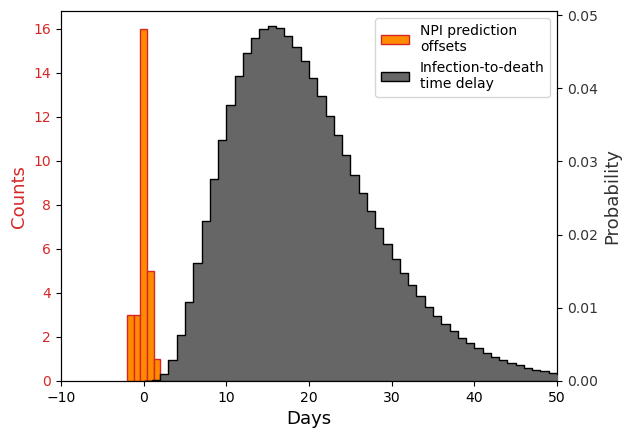

In [18]:
ax = plt.gca()
lns1 = ax.hist(ser, bins=int(1 + max(ser) - min(ser)), ec='tab:red',
               fc='darkorange', label='NPI prediction\noffsets', zorder=-20)
ax.set_xlabel('Days', fontsize=13)
ax.set_ylabel('Counts', fontsize=13, color='tab:red')
ax.tick_params(axis='y', labelcolor='tab:red')
ax.legend()

axd = ax.twinx()
lns2 = axd.fill_between(np.arange(60), ID_kernel[:60], zorder=20, ec='0.0',
                        fc='0.4', step='post', label='Infection-to-death\ntime delay')
axd.set_ylabel('Probability', fontsize=13, color='0.2')
axd.tick_params(axis='y', labelcolor='0.2')

plt.xlim(-10, 50)
plt.ylim(0, ID_kernel[:60].max() + 0.002)

leg = [lns1[2][0], lns2]
labs = [l.get_label() for l in leg]
ax.legend(leg, labs, loc=0)

for ex in ['.pdf', '.svg', '.png']:
    plt.savefig('fig5' + ex, transparent=True, bbox_inches='tight')
plt.show()